In [112]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Github Repos/resnet-50")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, Add,
    MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Input, ZeroPadding2D
)
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.models import Model

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

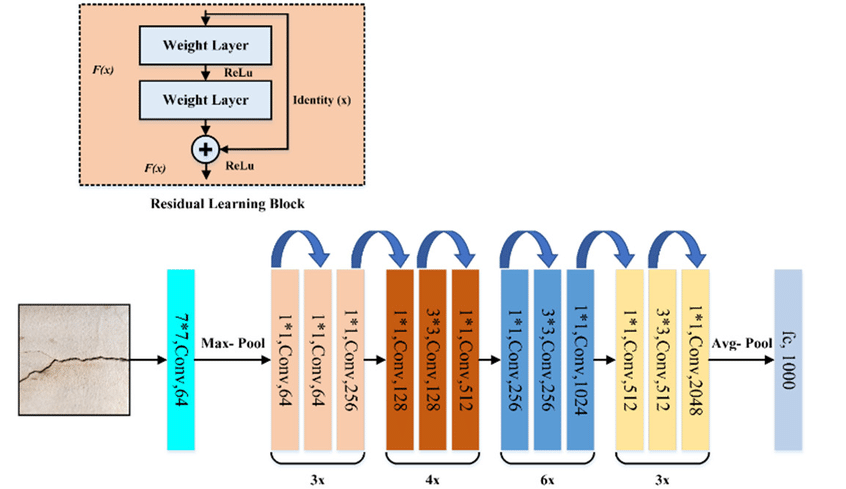

In [113]:
from IPython.display import Image, display
display(Image(filename='images/resnet.png', height=400, width=800))

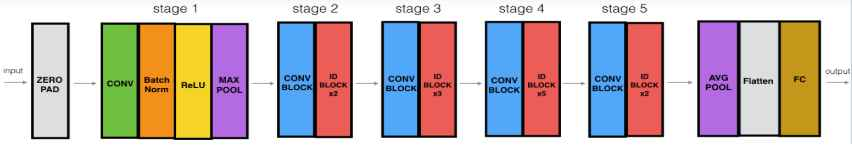

In [114]:
display(Image(filename='images/resnet_.jpg', height=200, width=800))

In [115]:
def identity_block(X, f, filters, initializer=random_uniform):
    """
    Implementation of the identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    F1, F2, F3 = filters
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3,)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    # Add shortcut value to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [116]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    F1, F2, F3 = filters
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    # SHORTCUT PATH
    X_shortcut = Conv2D(filters=F3, kernel_size=1, strides=s, padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Add shortcut value to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [117]:
def ResNet50(input_shape = (64, 64, 3), classes = 6, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, 3, [128 ,128, 512], s = 2)
    X = identity_block(X, 3, [128 ,128, 512])
    X = identity_block(X, 3, [128 ,128, 512])
    X = identity_block(X, 3, [128 ,128, 512])

    # Stage 4
    X = convolutional_block(X, 3, [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, 3, [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL
    X = GlobalAveragePooling2D()(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs = X_input, outputs = X)

    return model

In [118]:
model = ResNet50(input_shape = (32, 32, 3), classes = 3)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 38, 38, 3) │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_265 (Conv2D) │ (None, 16, 16,    │      9,472 │ zero_padding2d_5… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_265[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_245      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 7, 7, 64)  │          0 │ activation_245[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_266 (Conv2D) │ (None, 7, 7, 64)  │      4,160 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_266[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_246      │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_267 (Conv2D) │ (None, 7, 7, 64)  │     36,928 │ activation_246[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_267[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_247      │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_268 (Conv2D) │ (None, 7, 7, 256) │     16,640 │ activation_247[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_269 (Conv2D) │ (None, 7, 7, 256) │     16,640 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_268[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_269[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_80 (Add)        │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_248      │ (None, 7, 7, 256) │          0 │ add_80[0][0]      │
│ (Activation)        │                   │            │                 

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [119]:
np.random.seed(1)
tf.random.set_seed(2)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [120]:
(X_train_org, y_train_org), (X_test_org, y_test_org) = cifar10.load_data()
print('X_train_org Shape:', X_train_org.shape)
print('y_train_org Shape:', y_train_org.shape)
print('X_test_org Shape:', X_test_org.shape)
print('y_test_org Shape:', y_test_org.shape)

X_train_org Shape: (50000, 32, 32, 3)
y_train_org Shape: (50000, 1)
X_test_org Shape: (10000, 32, 32, 3)
y_test_org Shape: (10000, 1)


In [124]:
target_classes = [0, 1, 2]
train_samples_per_class = 1000

X_train_small, y_train_small = [], []

for class_idx in target_classes:
    # Training subset
    train_idx = np.where(y_train_org.flatten() == class_idx)[0][:train_samples_per_class]
    X_train_small.append(X_train_org[train_idx])
    y_train_small.append(y_train_org[train_idx])

# Concatenate all classes into one array
X_train_small = np.concatenate(X_train_small, axis=0)
y_train_small = np.concatenate(y_train_small, axis=0)

print("X_train_small shape:", X_train_small.shape)
print("y_train_small shape:", y_train_small.shape)

X_train_small shape: (3000, 32, 32, 3)
y_train_small shape: (3000, 1)


In [125]:
X_train = X_train_small.astype('float32') / 255.0
y_train = to_categorical(y_train_small, num_classes=3)

# Print shapes
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)

X_train Shape: (3000, 32, 32, 3)
y_train Shape: (3000, 3)


In [127]:
history = model.fit(X_train, y_train, epochs=15)

Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - Precision: 0.9342 - Recall: 0.9270 - accuracy: 0.9291 - loss: 0.2293
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - Precision: 0.9490 - Recall: 0.9437 - accuracy: 0.9465 - loss: 0.1542
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - Precision: 0.9429 - Recall: 0.9402 - accuracy: 0.9420 - loss: 0.1540
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - Precision: 0.9259 - Recall: 0.9218 - accuracy: 0.9238 - loss: 0.2315
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - Precision: 0.9584 - Recall: 0.9575 - accuracy: 0.9584 - loss: 0.1165
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - Precision: 0.9868 - Recall: 0.9865 - accuracy: 0.9868 - loss: 0.0429
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - Precision: 0.9866 - Recall: 0.9866 - accuracy: 0.9866 - loss: 0.0371
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - Precision: 0.9893 - Recall: 0.9886 - accuracy: 0.9886 - loss: 0.0391
Epoch 9/15
94/94 ━━━━━━━

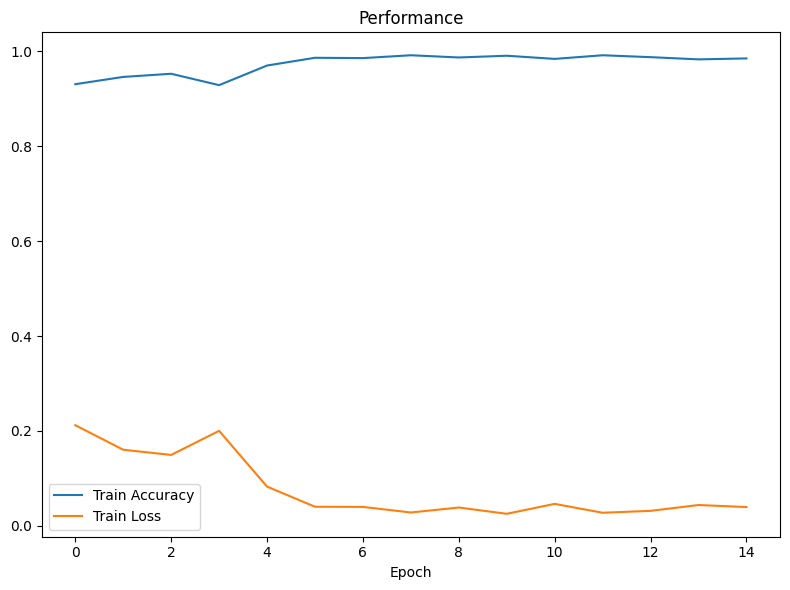

In [129]:
acc     = history.history['accuracy']
loss     = history.history['loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, loss, label='Train Loss')

plt.title('Performance')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

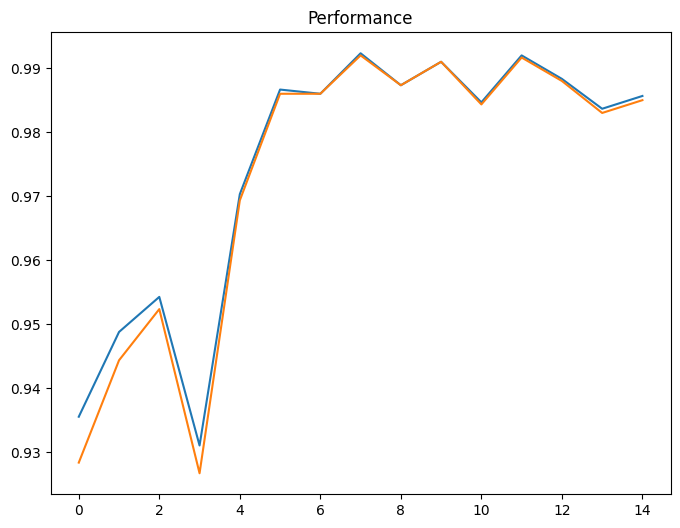

In [132]:
prec    = history.history['Precision']
rec     = history.history['Recall']

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, prec, label='Train Precision')
plt.plot(epochs_range, rec, label='Train Recall')

plt.title('Performance')
plt